In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

# Question 2: Applied ML

We would like to classify text data into 20 news groups using a mathod called term frequency–inverse document frequency (TD-IF). 

We start by loading the data from the scikit-learn library. The data set offers a train and a test subset, but we don't know the size of the split in terms of percentage and moreover we would like to split the data into three subsets. Therefore we use the argument subset= 'all' that return the whole data with shuffled ordering.

In [66]:
from sklearn.datasets import fetch_20newsgroups
#get the full data shuffled in order to split it our own way
newsgroup_full = fetch_20newsgroups(subset= 'all')
#displays the 20 categories that we aim to classify
newsgroup_full.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We will now convert the list of documents in the data into a matrix of TD-IF features.

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
#create a verctorizer
vectorizer = TfidfVectorizer()
#compute the TD-IDF features for every article
vectors = vectorizer.fit_transform(newsgroup_full.data)

As we said before we would like to split our data into three subsets. A training data, to train our model, a test data to select our parameters and validation data to validate our model.
The training data corresponds to 80% of the data and the test and validation set are respectively correspond to 10% of the original data

In [69]:
#compute the number of samples for the training data which equals 80% of the data
train_size = round(vectors.shape[0]/100*80)
#compute the number of samples for the test data which equals 10% of the data
test_val_size = round(vectors.shape[0]/100*10)

#training data
newsgroup_train = vectors[:train_size]
#training labes
y_train = newsgroup_full.target[:train_size]
#test data
newsgroup_test = vectors[train_size:train_size+test_val_size]
#test labels
y_test = newsgroup_full.target[train_size:train_size+test_val_size]
#validation data
newsgroup_validation = vectors[train_size+test_val_size:]
#validation labels
y_valid = newsgroup_full.target[train_size+test_val_size:]

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

We use a random forest in order to build our classifier. We then perform a grid search on the parameters n_estimators and max depth. For each pair of parameters we see how the model perfoms against the test set and keep track of the best parameters.

In [230]:
#the random forest classifier
rf = RandomForestClassifier()
best_score = 0
best_score_index = 0,0
accuracy = []
#grid search for the parameters
for estimators in range(10,40):
    for depth in range(10,40):
        rf.n_estimators = estimators
        rf.max_depth = depth
        rf.fit(newsgroup_train, y_train)
        pred = rf.predict(newsgroup_test)
        score = accuracy_score(y_test,pred)
        #compute the accuracy score
        accuracy.append(score)
        if score > best_score:
            best_score = score
            best_score_index = (estimators, depth)


We can plot the accuracy score as a surface to see how it evolve

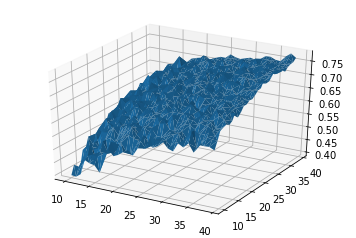

In [231]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(np.repeat(range(10,40), 30), np.tile(range(10,40),30), accuracy)
plt.show()

In [288]:
print("Best score:", best_score)
print("Parameters for best score:", best_score_index)

Best score: 0.779310344828
Parameters for best score: (38, 39)


We train another classifier with the best supposed paremeters and look at how it performs against an unseen data wich is the validation set.

In [289]:
best_forest = RandomForestClassifier(n_estimators=best_score_index[0], max_depth=best_score_index[1])
best_forest.fit(newsgroup_train, y_train)
print("Accuracy score of the validation data",accuracy_score(y_valid, best_forest.predict(newsgroup_validation)))


Accuracy score of the validation data 0.774416135881


The accuracy score of the validation data compare to the test data is pretty close therefore we know that we didn't overfit our test data.

We can now plot the confusion matrix. 
To do so we wrote a code inspired from this post:<br> https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python

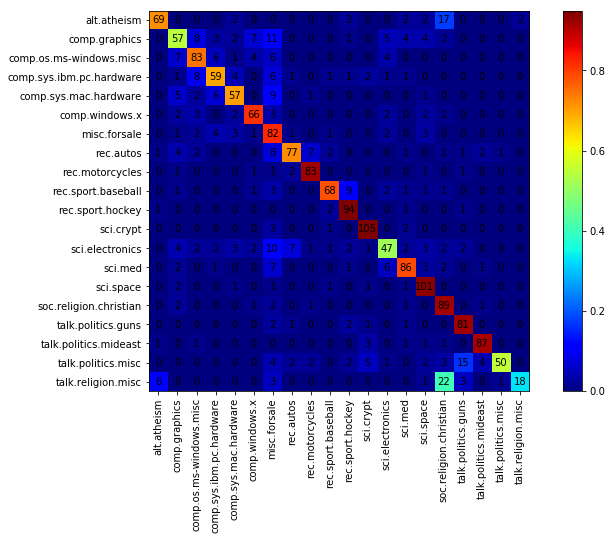

In [294]:
norm_confusion = []
confusion = confusion_matrix(y_valid, best_forest.predict(newsgroup_validation))                           
for i in confusion:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_confusion.append(tmp_arr)

fig = plt.figure(figsize = (12,7))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_confusion), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = confusion.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(confusion[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
ax.set_xticklabels(newsgroup_full.target_names, minor=False, rotation='vertical')
ax.set_xticks(np.arange(len(newsgroup_full.target_names)))
ax.set_yticklabels(newsgroup_full.target_names, minor=False)
ax.set_yticks(np.arange(len(newsgroup_full.target_names)))      
plt.show()

The heatmap of the confusion matrix shows that our classifier did well is most cases. The diagonal is clearly highlighted. We can see that the model had some trouble to classify the newsgroup $\text{talk.religion.misc}$ almost half of the data for this group was wrongly classified to $\text{soc.religion.christian}$. First of all it was still classified as a religious group which is nice. The other reason is that if we look at the christian group we see that it has more data, the output are not balanced for this two categories. Therefore the model tends to classify more easily the group with more data. This could be attenuate with a cost function if we use another classification model therefore this visualization still contains a lot of information.

In [284]:
print(best_forest.feature_importances_[:10])
len(best_forest.feature_importances_.nonzero()[0])/len(best_forest.feature_importances_)*100

[  1.05065258e-04   1.97086444e-04   1.25237515e-05   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


8.272809935428919

As we can see most of the weights are zero. Only ~8.3% of the weights are non-zero. Therfore it means that the model found relevant informations only in the non-zero features. We could thus remove some features to do faster computations.
